### Intro to K-means Clustering
K-means is mathematically and conceptually straightforward but computationally intensive. It produced hard clusters that are similar to one another and have similar variance.

The cost function employed is called __inertia__, and the algorithm tries to choose means (centroids) that minimize the inertia. The inertia formula is:
$$\sum(\bar{x}_c - x_i)^2$$
You will recognize this as the sum of the squared differences for each centroid and the datapoints put in that cluster. The ultimate point is to create centroids with a minimum distance between the centroid mean and its points. The *means* in k-means refers to these centroids.

The number of centroids (= number of clusters) is provided by the user. K is picked through trial and error to see which one works best/has the most practical application, but there is no set rule for this. In general, clusters representing "real" and "meaningful" divisions in the data will be stable across test and training sets.

### Mechanics of the algorithm
In practice, this is an iterative algorithm that eventually converges on a solution (hence why it is computationally costly). It performs the following steps in succession:
1. Pick k centroids at random
2. Assign each data point to its nearest centroid
3. Create new centroids by taking the mean of all the data points assigned to each centroid (honing this in further)

This process continues until the difference between centroids is below a given threshold. Since it starts at random, K clustering is liable to arrive at a lousy solution. As such, it is recommended to start with different centroids. Sklearn has a `kmeans++` option for initializing centroids that are distant from each other, which is less likely to end in a flawed solution.

### Assumptions of k-means clustering
K-means clustering assumes that the underlying, true clusters are radially symmetrical or isotropic, meaning that they are:
- Uniform in all directions
- Have edges that curve outwards
- Assumes clusters have similar variances
Pictures of clusters that do and don't conform to these rules can be found [here](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py)

### Practical Constraints
High dimensional data can make KNN run more slowly since it's more computationally demanding. It's commong to run PCA first in these situations.

However, if you don't want to reduce dimensions since you want to retain visibility on the specific features, then you can use `MiniBatchKmeans`, which randomly samples subsets of the training data in each iteration. The loop steps are similar to those in the original:
1. Assign samples to nearest centroids.
2. Update centroids based on the streaming average of all of the samples that have been assigned to the centroid so far.
This will arrive at a solution quite a bit faster, though you can expect the results to be slightly worse.

##### Applying the model with some [heart disease data](http://archive.ics.uci.edu/ml/datasets/Heart+Disease)....

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

In [2]:
# Reading in data and specifying target vars
df = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/cleveland.csv", header=None, error_bad_lines=False)

# Define the features and the outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

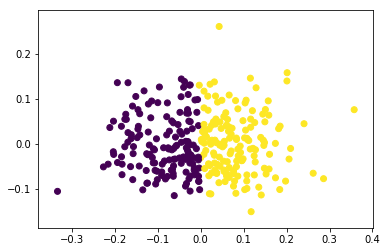

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      84  65
1      55  99
0.6039603960396039


In [6]:
# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))
from sklearn import metrics
print(metrics.accuracy_score(y_pred,y))

Notice in the above that the model is not doing great, getting only about 60% of the predictions correct. Now let's try minibatch, which we expect to be faster but a little less accurate.

In [12]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))
print(metrics.accuracy_score(predict_mini,y))

Comparing k-means and mini batch k-means solutions:
col_0    0    1
row_0          
0       11  154
1      138    0
0.3795379537953795


In [13]:
%timeit predict_mini = minibatchkmeans.fit_predict(X_pca)
%timeit y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

8.89 ms ± 401 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
21.5 ms ± 582 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Note that the minibatchmeans technique of clustering is much less accurate, but runs more than twice as fast. Let's see how we can improve performance by messing with the clustering process.

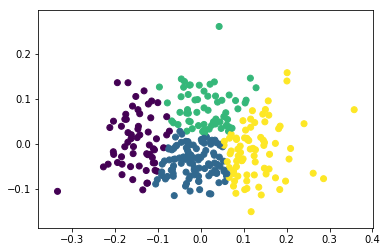

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      40  21
1      37  67
2      42  20
3      20  56
0.35313531353135313


In [95]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=4, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
crosstab = pd.crosstab(y_pred, y)
print(pd.crosstab(y_pred, y))
from sklearn import metrics
print(metrics.accuracy_score(y_pred,y))

In [96]:
crosstab

col_0,0,1
row_0,,
0,40,21
1,37,67
2,42,20
3,20,56


In [97]:
crosstab.index

Int64Index([0, 1, 2, 3], dtype='int64', name='row_0')

In [98]:
# Storing results for categorization of each cluster
indication = np.array([])

# Creating a loop that calculates, for each row, whether it indicates heart disease or no heart disease
# Then classifying it as such in y_pred
# And calculating the accuracy of those predictions
for row in crosstab.index:
    if crosstab.iloc[row,0] >= crosstab.iloc[row,1]:
        ind = 'neg'
    else: 
        ind = 'pos'
    indication = np.append(indication,ind)
    
# Creating a function to reduce each cluster to their most common indication
def Reducer(x):
    diagnosis = 0
    if indication[x] == 'pos':
        diagnosis = 1
    return diagnosis

# Reducing y_pred to the different categorization groupings
y_pred_new = pd.Series(y_pred)
y_pred_new = y_pred_new.apply(Reducer)

# Calculating accuracy
print('Accuracy = {0:0.2f}%'.format(metrics.accuracy_score(y,y_pred_new)))

Accuracy = 0.68%


Let's loop this whole thing to get a better idea of optimal number of clusters for the question at hand.

In [108]:
del indication

In [115]:
# Clusters to try
num_clusters=np.arange(2,300)
accuracies=np.array([])

for num in num_clusters:
    # Calculate predicted values.
    y_pred = KMeans(n_clusters=num, random_state=42).fit_predict(X_pca)
    crosstab = pd.crosstab(y_pred, y)

    # Storing results for categorization of each cluster
    indication = np.array([])

    # Creating a loop that calculates, for each row, whether it indicates heart disease or no heart disease
    # Then classifying it as such in y_pred
    # And calculating the accuracy of those predictions
    for row in crosstab.index:
        if crosstab.iloc[row,0] >= crosstab.iloc[row,1]:
            ind = 'neg'
        else: 
            ind = 'pos'
        indication = np.append(indication,ind)

    # Creating a function to reduce each cluster to their most common indication
    def Reducer(x):
        diagnosis = 0
        if indication[x] == 'pos':
            diagnosis = 1
        return diagnosis

    # Reducing y_pred to the different categorization groupings
    y_pred_new = pd.Series(y_pred)
    y_pred_new = y_pred_new.apply(Reducer)

    # Calculating accuracy
    accuracy = metrics.accuracy_score(y,y_pred_new)
    accuracies = np.append(accuracies,accuracy)

for pair in zip(num_clusters,accuracies):
    print(pair)

(2, 0.6039603960396039)
(3, 0.594059405940594)
(4, 0.6765676567656765)
(5, 0.6600660066006601)
(6, 0.6435643564356436)
(7, 0.6567656765676567)
(8, 0.636963696369637)
(9, 0.6468646864686468)
(10, 0.6534653465346535)
(11, 0.6864686468646864)
(12, 0.6831683168316832)
(13, 0.6897689768976898)
(14, 0.6765676567656765)
(15, 0.6666666666666666)
(16, 0.6831683168316832)
(17, 0.6963696369636964)
(18, 0.6963696369636964)
(19, 0.693069306930693)
(20, 0.6963696369636964)
(21, 0.6765676567656765)
(22, 0.6798679867986799)
(23, 0.693069306930693)
(24, 0.6864686468646864)
(25, 0.6831683168316832)
(26, 0.7128712871287128)
(27, 0.6996699669966997)
(28, 0.6996699669966997)
(29, 0.6996699669966997)
(30, 0.7095709570957096)
(31, 0.693069306930693)
(32, 0.7161716171617162)
(33, 0.7029702970297029)
(34, 0.6963696369636964)
(35, 0.7095709570957096)
(36, 0.7128712871287128)
(37, 0.7128712871287128)
(38, 0.7260726072607261)
(39, 0.7161716171617162)
(40, 0.7293729372937293)
(41, 0.7128712871287128)
(42, 0.722772

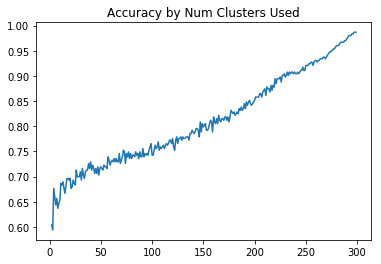

In [116]:
plt.plot(num_clusters,accuracies)
plt.title("Accuracy by Num Clusters Used")
plt.show()

Accuracy continues to increase as the number of clusters increases. However, it eventually doesn't make sense to create so many clusters since then you're just fitting to each observation in particular (303 in total), or in other words severely overfitting.